In [60]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
from keras import models
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(True)

In [2]:
path_hindi = "./BHSig260/Hindi/"

In [3]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path_hindi))[1]
dir_list.sort()

In [4]:
data_groups = []
for directory in dir_list:
    images = os.listdir(path_hindi+directory)
    images.sort()
    images = [path_hindi+directory+'/'+x for x in images]
    data_groups.append(images)

In [5]:
path_bengali = "./BHSig260/Bengali/"

In [6]:
dir_list = next(os.walk(path_bengali))[1]
dir_list.sort()

In [7]:
for directory in dir_list:
    images = os.listdir(path_bengali+directory)
    images.sort()
    images = [path_bengali+directory+'/'+x for x in images]
    data_groups.append(images)

In [8]:
# path_english = "./BHSig260/English/"
# dir_list = next(os.walk(path_english))[1]
# dir_list.sort()
# for directory in dir_list:
#     images = os.listdir(path_english+directory)
#     images.sort()
#     images = [path_english+directory+'/'+x for x in images]
#     forg_groups.append(images[:5]) # First 5 signatures in each folder are forrged
#     orig_groups.append(images[5:]) # Next 5 signatures are genuine

In [9]:
# Quick check to confirm we have data of all the 160 individuals
len(data_groups)

260

In [10]:
data_lengths = [len(x) for x in data_groups]

In [11]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(data_lengths)

[54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,

#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [12]:
train, test = train_test_split(data_groups, test_size=10/260, random_state=1)
train, val = train_test_split(train, test_size=10/250, random_state=1)

# orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
# forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [13]:
train_size = len(train)
test_size = len(test)
val_size = len(val)
print(len(train), len(val), len(test))

240 10 10


In [14]:
# Delete unnecessary variables
del data_groups

In [15]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [16]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    k = np.random.randint(len(train))
    img_names = random.sample(train[k], 2)
    label1 = 0 if "F" in img_names[0] else 1
    label2 = 0 if "F" in img_names[1] else 1
    img1 = cv2.imread(img_names[0], 0)
    img2 = cv2.imread(img_names[1], 0)
    img1 = cv2.resize(img1, (img_w, img_h))
    img2 = cv2.resize(img2, (img_w, img_h))

    ax1.imshow(img1, cmap = 'gray')
    ax2.imshow(img2, cmap = 'gray')

    ax1.set_title('Genuine Copy' if label1 == 1 else 'Forged Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy' if label2 == 1 else 'Forged Copy')
    ax2.axis('off')
    plt.show()


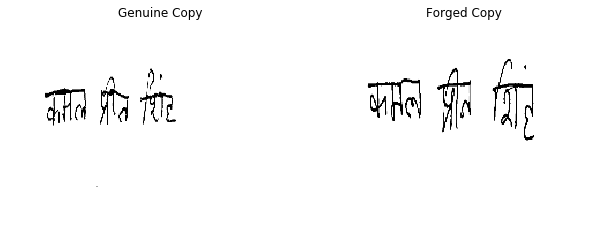

In [17]:
visualize_sample_signature()

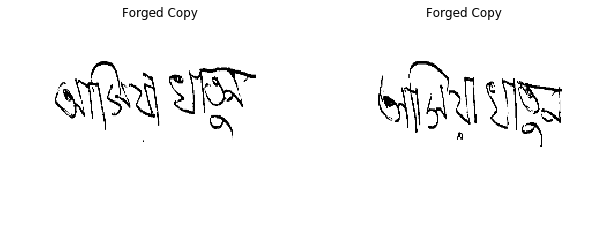

In [18]:
visualize_sample_signature()

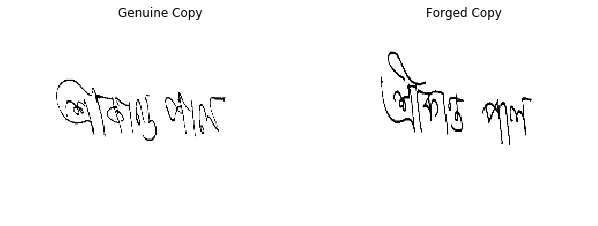

In [19]:
visualize_sample_signature()

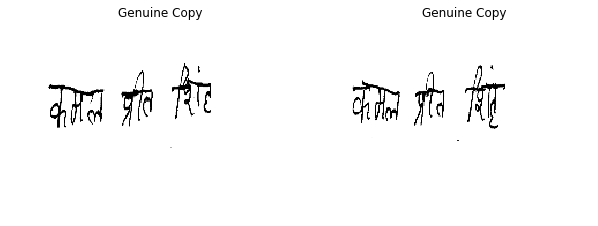

In [20]:
visualize_sample_signature()

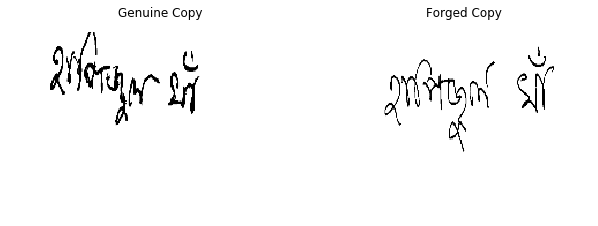

In [21]:
visualize_sample_signature()

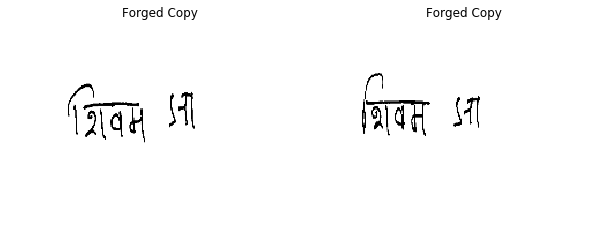

In [22]:
visualize_sample_signature()

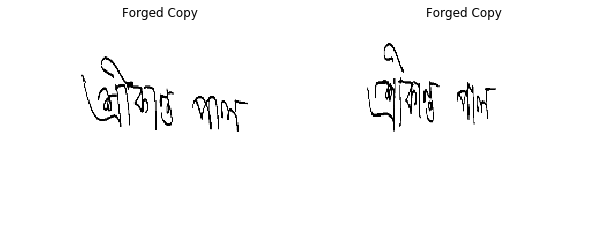

In [23]:
visualize_sample_signature()

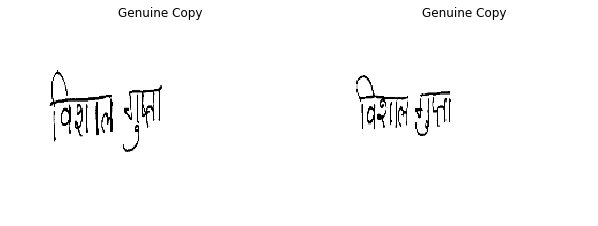

In [24]:
visualize_sample_signature()

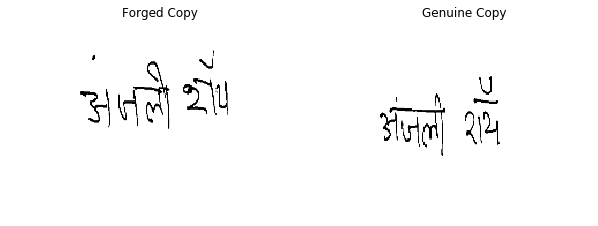

In [25]:
visualize_sample_signature()

In [28]:
def generate_batch(data_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        images = []
        labels = []
        for author in data_groups:
            for image in author:
                images.append(image)
        
        images = shuffle(images)
        k = 0
        batch=np.zeros((batch_size, img_h, img_w, 1))
        targets=np.zeros((batch_size,))
        for ix, image in enumerate(images):
            img1 = cv2.imread(image, 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img1 /= 255
            img1 = img1[..., np.newaxis]
            batch[k, :, :, :] = img1
            targets[k] = 0 if 'F' in image else 1
            k += 1
            if k == batch_size:
                yield batch, targets
                k = 0
                batch=np.zeros((batch_size, img_h, img_w, 1))
                targets=np.zeros((batch_size,))

In [29]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [30]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [31]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [32]:
def create_base_network_signet(input_shape):
    '''Base Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(128, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(512, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    seq.add(Dense(1))
    
    return seq

In [34]:
input_shape=(img_h, img_w, 1)

In [35]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
# input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
# processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
# distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a])

model = Model(input=[input_a], output=processed_a)
p_model = multi_gpu_model(model, gpus=4)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_size=(11, 11), kernel_initializer="glorot_uniform", activation="relu")`
  
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  import sys


/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  if __name__ == '__main__':
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, name="conv2_1", data_format="channels_last", strides=1, kernel_initializer="glorot_uniform", kernel_size=(5, 5), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  if sys.path[0] == '':
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(

In [36]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
p_model.compile(loss=contrastive_loss, optimizer=rms)
p_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 155, 220, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 155, 220, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 155, 220, 1)  0           input_1[0][0]                    
____________________________________________________________________________________________

In [37]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/cnn-bhsig260-full-xavier-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [38]:
batch_sz = 48
num_train_samples = train_size
num_val_samples = val_size
num_test_samples = test_size
num_train_samples, num_val_samples, num_test_samples

(240, 10, 10)

In [39]:

results = p_model.fit_generator(generate_batch(train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(val, 10),
                              validation_steps = num_val_samples//10,
                              callbacks = callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
5/5 [==============================] - 7s 1s/step - loss: 9.1266 - val_loss: 1.1803

Epoch 00001: saving model to ./Weights/cnn-bhsig260-full-xavier-001.h5
Epoch 2/100
5/5 [==============================] - 0s 23ms/step - loss: 1.3874 - val_loss: 0.6178

Epoch 00002: saving model to ./Weights/cnn-bhsig260-full-xavier-002.h5
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 1.2992 - val_loss: 0.7971

Epoch 00003: saving model to ./Weights/cnn-bhsig260-full-xavier-003.h5
Epoch 4/100
5/5 [==============================] - 0s 51ms/step - loss: 0.9424 - val_loss: 0.8538

Epoch 00004: saving model to ./Weights/cnn-bhsig260-full-xavier-004.h5
Epoch 5/100
5/5 [==============================] - 1s 103ms/step - loss: 1.1130 - val_loss: 0.6463

Epoch 00005: saving model to ./Weights/cnn-bhsig260-full-xavier-005.h5
Epoch 6/100
5/5 [==============================] - 0s 96

In [40]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR and P-R curves to measure performance on input set
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.00001
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [41]:
def load_and_check_model(weight):
    model.load_weights(weight)

    val_gen = generate_batch(val, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        img1, label = next(val_gen)
        tr_y.append(label)
        pred.append(model.predict(img1))

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold

#### BHSIG260 full dataset with Xavier Initialisation on Uniform Distribution

In [43]:
acc_thresh = []
for i in range(1,18,1):
    acc_thresh.append(load_and_check_model('./Weights/cnn-bhsig260-full-xavier-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

For model 1 Validation Accuracy =  60.0 %
For model 2 Validation Accuracy =  80.0 %
For model 3 Validation Accuracy =  66.66666666666666 %
For model 4 Validation Accuracy =  60.00000000000001 %
For model 5 Validation Accuracy =  80.0 %
For model 6 Validation Accuracy =  75.0 %
For model 7 Validation Accuracy =  62.5 %
For model 8 Validation Accuracy =  71.42857142857143 %
For model 9 Validation Accuracy =  78.57142857142857 %
For model 10 Validation Accuracy =  50.0 %
For model 11 Validation Accuracy =  75.0 %
For model 12 Validation Accuracy =  90.0 %
For model 13 Validation Accuracy =  66.66666666666666 %
For model 14 Validation Accuracy =  70.0 %
For model 15 Validation Accuracy =  70.83333333333333 %
For model 16 Validation Accuracy =  56.25 %
For model 17 Validation Accuracy =  78.57142857142857 %


In [44]:
def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        img1, label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict(img1))

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

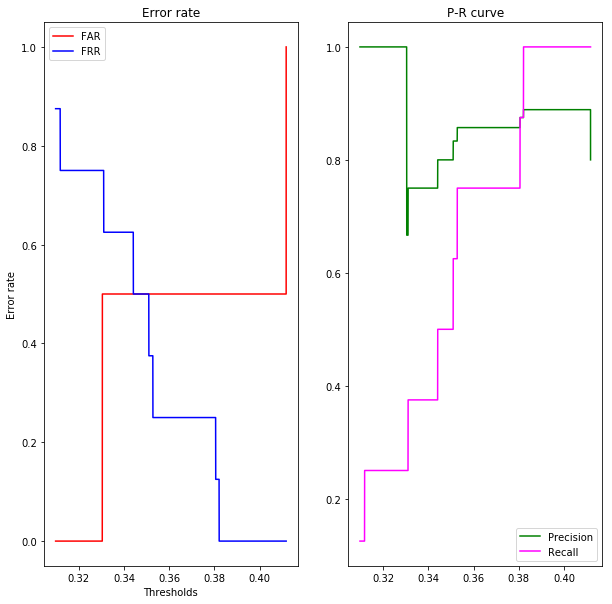

(0.75, 0.3820525344658622)

In [45]:
acc, threshold = test_model('./Weights/cnn-bhsig260-full-xavier-002.h5')
acc, threshold

#### Accuracy = 75.00% and Threshold = 0.38 Using Xavier Initialisation on Uniform distribution
Thus if the prediction is less than 0.38 we predict the test image as Forged and if the difference score is greater than 0.38 we predict it to be as Denuine

#### Below we see some sample results

In [46]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(test, 1)
    test_point, test_label = next(test_gen)
    img1 = test_point
    print('True Label = ',test_label)
    fig, (ax1) = plt.subplots(1, 1, figsize = (8, 8))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    result = model.predict(img1)
    print("Predicted Label = ", result)
    if result > threshold:
        print("Its a Genuine Signature")
        ax1.set_title('Genuine')
    else:
        print("Its a Forged Signature")
        ax1.set_title('Forged')
    ax1.axis('off')

True Label =  [0.]
Predicted Label =  [[0.33268696]]
Its a Forged Signature


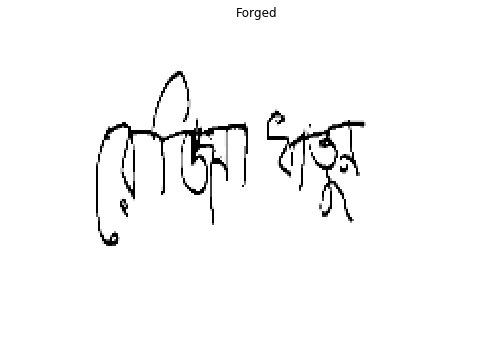

In [47]:
predict_score()

True Label =  [0.]
Predicted Label =  [[0.3633049]]
Its a Forged Signature


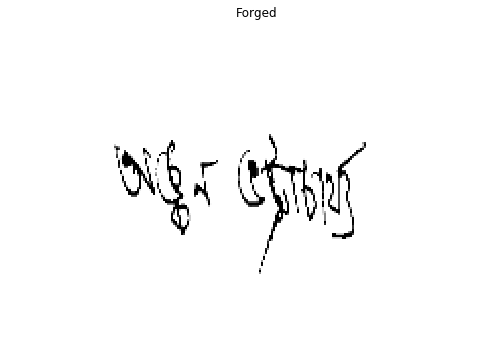

In [49]:
predict_score()

True Label =  [0.]
Predicted Label =  [[0.3082034]]
Its a Forged Signature


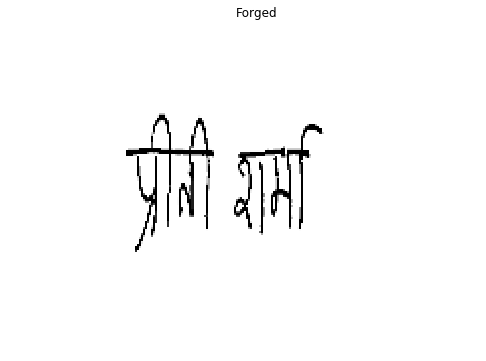

In [54]:
predict_score()

True Label =  [0.]
Predicted Label =  [[0.38010284]]
Its a Forged Signature


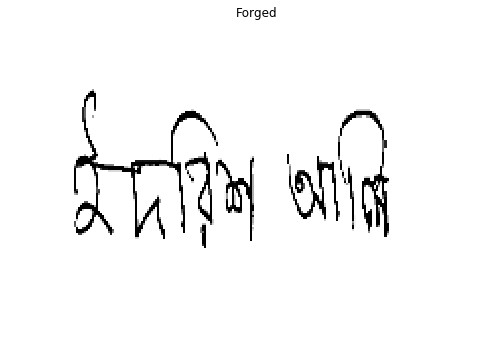

In [57]:
predict_score()

#### Visualising Network Activations

The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

Intermediate activations are useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.

In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we’ll use the Keras class Model. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models, mapping the specified inputs to the specified outputs. What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential.

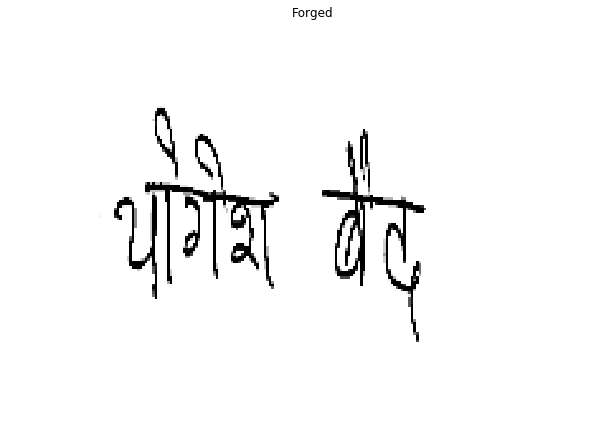

/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


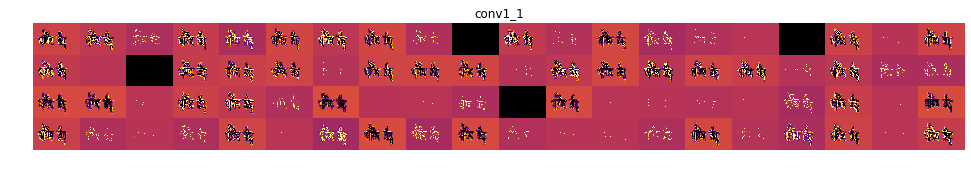

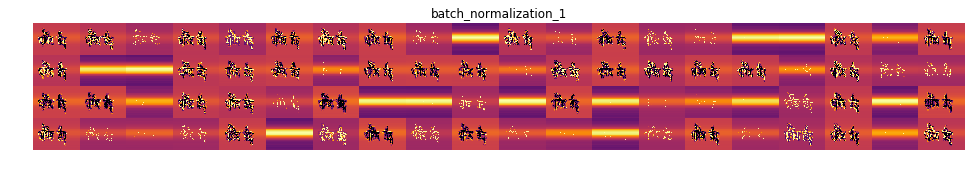

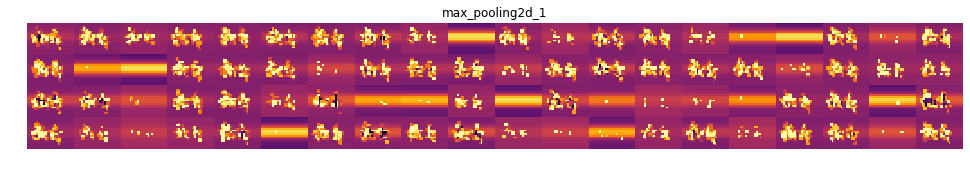

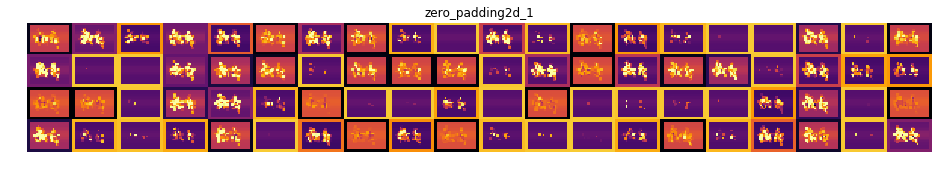

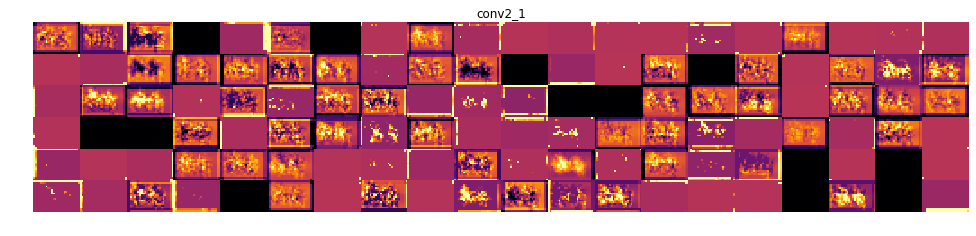

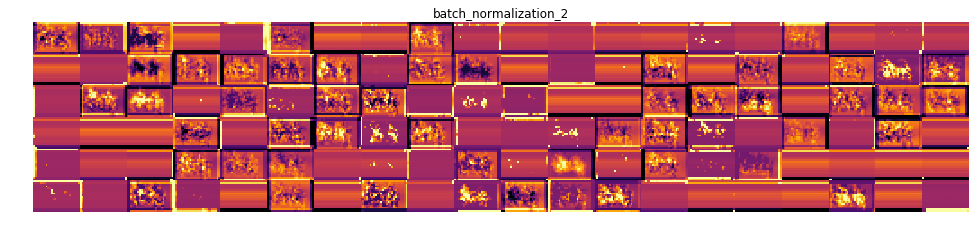

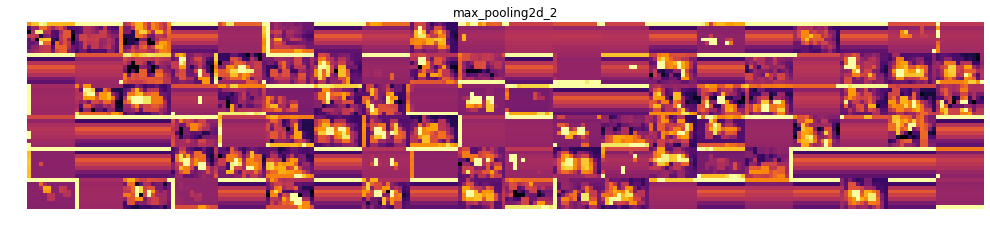

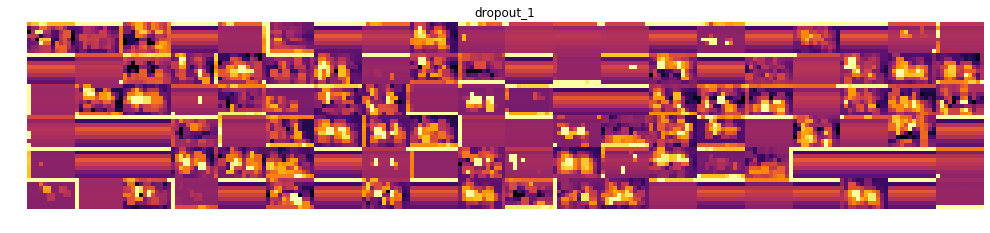

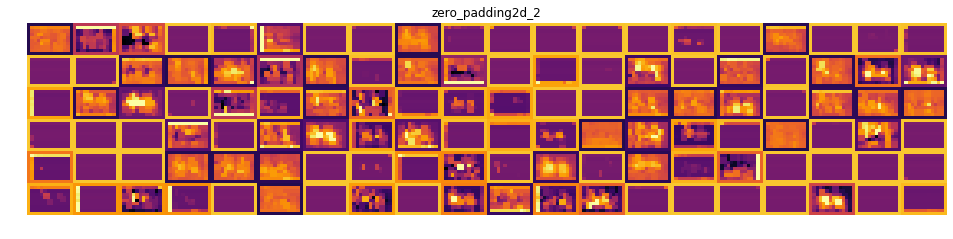

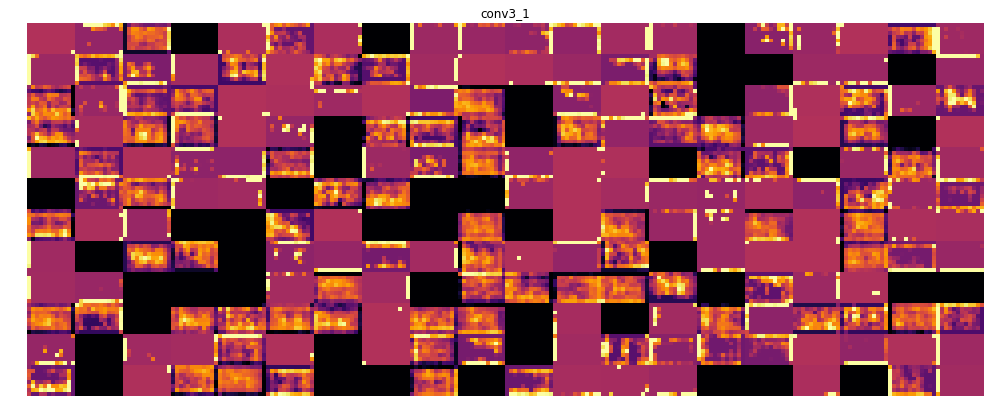

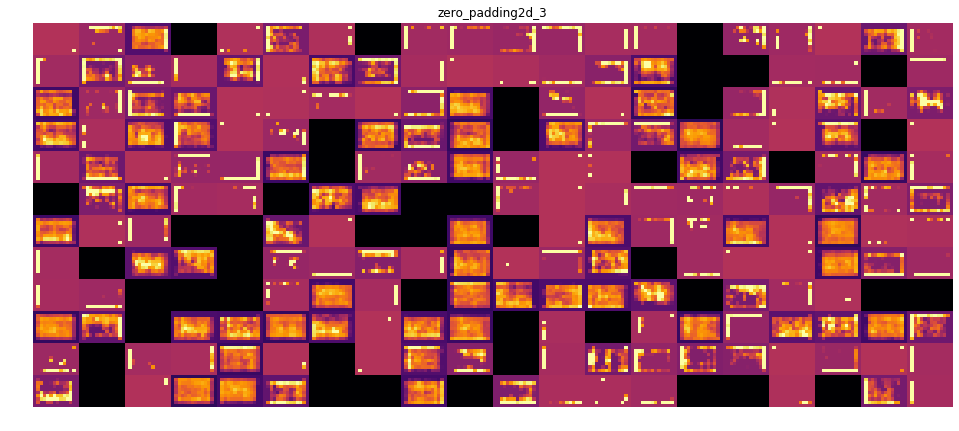

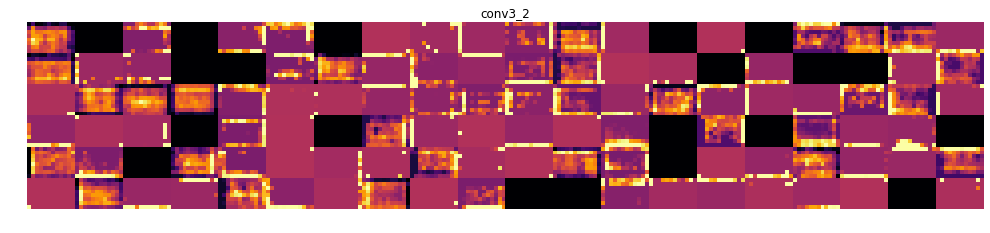

In [63]:
test_gen = generate_batch(test, 1)
test_point, test_label = next(test_gen)
img1 = test_point
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax1.set_title('Genuine')
if test_label == 1:
    ax1.set_title('Genuine')
else:
    ax1.set_title('Forged')
ax1.axis('off')
plt.show()

branched_model = base_network
layer_outputs = [layer.get_output_at(-1) for layer in branched_model.layers[:20]] # Extracts the outputs of the top 12 layers
inputs_at_node = branched_model.get_input_at(0)
print


activation_model = models.Model(inputs=inputs_at_node, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict([img1]) # Returns a list of five Numpy arrays: one array per layer activation
layer_names = []
for layer in branched_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size_c = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    size_r = layer_activation.shape[2] #The feature map has shape (1, size, size, n_features).
#     print(layer_activation.shape)
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size_c * n_cols, images_per_row * size_r))
#     print(display_grid.shape)
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             print(row * size_r , (row + 1) * size_r,col * size_c  ,(col + 1) * size_c)
#             print(channel_image.shape)
            display_grid[col * size_c : (col + 1) * size_c,row * size_r : (row + 1) * size_r] = channel_image # Displays the grid
                         
    scale = 1. / (size_c+size_r/2)
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='inferno')